In [1]:
%cd /qbio/ari/works/SCV2_2022_re

/qbio/ari/works/SCV2_2022_re


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})

matplotlib.rcParams['ytick.labelright'] = True
matplotlib.rcParams['ytick.labelleft'] = False
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.left'] = False

In [4]:
orfcolors = {'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [5]:
anno = pd.read_csv('hy_/refs/SARS-CoV-2-annotations.gff'
                   , sep='\t', names=['chrom', 'type', 'name', 'start', 'end', 'x', 'y', 'z'])
cdsanno = anno[anno['type'] == 'CDS']
cdsanno = cdsanno.iloc[:10].sort_values(by='start').iloc[:9]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['chrSCV', 'CDS', 'ORF1a', 266, 13468, '.', '.', '.'], index=cdsanno.columns),
        pd.Series(['chrSCV', 'CDS', 'ORF1b', 13468, 21552, '.', '.', '.'], index=cdsanno.columns),
    ])])
cdsanno = cdsanno.sort_values(by='start').iloc[:, 2:5].reset_index(drop=True)
cdsanno['color'] = cdsanno['name'].apply(orfcolors.__getitem__)
#cdsanno.to_pickle('tmp/cdsannotation.pickle')
cdsanno

from Bio import Seq
from Bio import SeqIO

reference_sequence = 'hy_/refs/SARS-CoV-2-RNA.fa'
refseq = str(next(SeqIO.parse(reference_sequence, 'fasta')).seq).upper().replace('T', 'U')

In [6]:
SAMPLES_ALL = 'Korea_2020 Freiburg_2020_1 IVT_1 IVT_2'.split(' ')
SAMPLES_VIRAL = 'Korea_2020 Freiburg_2020_1'.split(' ')
SAMPLES_CTL = 'IVT_1 IVT_2'.split(' ')


In [7]:
viral_colors = {'Korea_2020':'crimson',
                'Freiburg_2020_1':'dodgerblue',
               }
sample_anno = {'Korea_2020': 'Kim, 2020',
             'Freiburg_2020_1': 'Miladi, 2020',
              'IVT_1': 'IVT 1',
               'IVT_2': 'IVT 2'}

In [8]:
modfracs = []
for file, name in zip([f'm6anet/try2/{name}/data.result.csv.gz' for name in SAMPLES_ALL],
              SAMPLES_ALL):
    stats = pd.read_csv(file, sep = ',', compression='gzip')
    stats['sample'] = name
    modfracs.append(stats)
modfracs = pd.concat(modfracs).sort_values(by=['transcript_id','transcript_position','sample'])
modfracs.columns = 'chr pos cov probability sample'.split(' ')

modfracs['pos'] +=1

In [9]:
modfrac_pivot = modfracs.pivot(index='pos', columns='sample', values='probability').fillna(0)
modfrac_pivot['IVT'] = (modfrac_pivot['IVT_1']+modfrac_pivot['IVT_2'])/2
modfrac_pivot_ = modfrac_pivot['Freiburg_2020_1 Korea_2020 IVT'.split(' ')]

In [11]:
import pickle
with open("fig_pickle/m6Anet_pivot.picke", "wb") as f:
    pickle.dump(modfrac_pivot_, f)

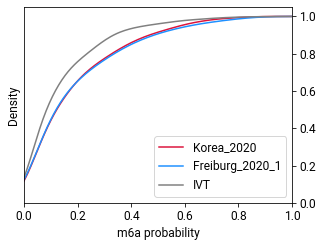

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4.8, 3.6))

for i, name in enumerate('Korea_2020 Freiburg_2020_1 IVT'.split(' ')):
    tempplot = modfrac_pivot_[name]
    try:
        c = viral_colors[name]
    except:
        c = 'grey'
    try:
        label = sample_anno[name]
    except:
        label = name
    sns.kdeplot(tempplot, cumulative=True,
               
                fill=False, color=c,
              label=name)

ax.set_xlim(0,  1)
#ax.axvline(frp, zorder=0, color='red', lw=1, alpha=.8)

ax.legend(loc='lower right')
ax.set_xlabel('m6a probability')
plt.savefig('figfinal/m6Aprob_curv.pdf')

In [15]:
frp = np.percentile(modfrac_pivot_['IVT'], 95)
frp

0.44500653599999973

In [16]:
MIN_COV = 500
class m6anet:
    
    def __init__(self, filelist, samples, frp):
        self.filelist = filelist
        self.samples = samples
        self.max_distance = 4
        self.minimum_coverage = MIN_COV
        self.min_modfrac = frp
    
    def load_combine_all(self):
        modfracs = []
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = ',', compression='gzip')
            stats['sample'] = name
            modfracs.append(stats)
        modfracs = pd.concat(modfracs).sort_values(by=['transcript_id','transcript_position','sample'])
        modfracs.columns = 'chr pos cov probability sample'.split(' ')
        
        modfracs['pos'] +=1
        return(modfracs)

    def get_modified_sites(self, hp_filter=True):
        positive_positions = set()
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = ',', compression='gzip')
            stats.columns = 'chr pos cov probability'.split(' ')

        
            stats_high = stats[(stats['cov']>=self.minimum_coverage)&
                               (stats['probability']>=self.min_modfrac)]
            positive_positions |= set(stats_high['pos'].tolist())

        modfracs=[]
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = ',', compression='gzip')
            stats['sample'] = name
            stats.columns =  'chr pos cov probability sample'.split(' ')
            modfracs.append(stats[stats['pos'].isin(positive_positions)])


        if len(modfracs) > 0:
            ret = pd.concat(modfracs).sort_values(by=['pos', 'sample']).reset_index(drop=True)
            ret['pos'] +=1
            return ret

    def aggregate_adjacent_sites(self, modfracs):

        modsites_raw = sorted(modfracs['pos'].unique())
        continuity = np.diff(modsites_raw) <= self.max_distance
        
        modsite_groups = [[modsites_raw.pop(0)]]
        for pos, cont in zip(modsites_raw, continuity):
            if cont:
                modsite_groups[-1].append(pos)
            else:
                modsite_groups.append([pos])

        purified = []
        for modsites in modsite_groups:
            modfracsites = modfracs[modfracs['pos'].isin(modsites)]

            modfracsites_high = modfracsites[modfracsites['cov'] >= self.minimum_coverage]
            maxpos = modfracsites.loc[modfracsites_high['probability'].idxmax()]
            purified.append(modfracsites[modfracsites['pos'] == maxpos['pos']])

        return pd.concat(purified)
    
    def summarize_into_table(self, aggrtbl):
        mod_frac_all = pd.pivot_table(aggrtbl, columns='sample', values=['probability'],
                                     index=['pos'])['probability'].copy()
        coverage = pd.pivot_table(aggrtbl, columns='sample', values=['cov'],
                                 index=['pos'])['cov'].copy()

        return mod_frac_all, coverage


def add_context_info(sitemodfrac, refseq, flanksize):
    context_list=[]
    for pos in sitemodfrac.index:
        pos = pos -1 # one based in end_loc
        context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
        
        context_list.append(context)
        
    return(context_list)


m6anet_analysis = m6anet([f'm6anet/try2/{name}/data.result.csv.gz' for name in SAMPLES_ALL],
              SAMPLES_ALL,
             frp)
m6anet_modfracs = m6anet_analysis.load_combine_all()
m6anet_freqmods = m6anet_analysis.get_modified_sites()
m6anet_psites = m6anet_analysis.aggregate_adjacent_sites(m6anet_freqmods)

m6anet_sitemodfrac, m6anet_sitecov= m6anet_analysis.summarize_into_table(m6anet_psites)

m6anet_sitemodfrac['context'] = add_context_info(m6anet_sitemodfrac, refseq, 10)


In [23]:
with open("fig_pickle/m6Anet_sitemodfrac.pickle", "wb") as f:
    pickle.dump(m6anet_sitemodfrac, f)

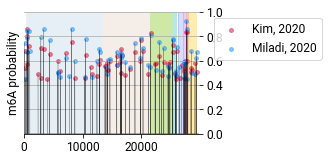

In [18]:
fig, ax = plt.subplots(1,1, facecolor='white', figsize=(4.8,2.4))

for sample in SAMPLES_VIRAL:
    
    name = sample
    plot_x = np.arange(len(refseq))
    plot_y = np.zeros(len(refseq))
    tempfrac = m6anet_sitemodfrac[m6anet_sitemodfrac[name]>=frp]

    plot_y[tempfrac[name].index] = tempfrac[name]
    
    ax.scatter(tempfrac.index, tempfrac[name],
                alpha=.5, s=15, label=sample_anno[name], c=viral_colors[name])
    
    ax.plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
ax.set_xlim(0, len(refseq))
ax.legend()
ax.set_ylabel('m6A probability')


for spside in 'top left right'.split():
    plt.setp(ax.spines[spside], visible=False)

ax.grid(True)
plt.setp(ax.get_xgridlines(), visible=False)

for _, row in cdsanno.iterrows():
    ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.4, zorder=0)
ax.set_ylim(0, 1)
plt.tight_layout()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()
plt.savefig('figfinal/m6Anet_output.pdf')

In [20]:
def meme(posdf):
    with open('temp_fasta.fa', 'w') as outpfile:
        for _, line in posdf.iterrows():
            #strand = line['strand']
            strand = '+'
            pos = _-1
            flanksize = 10
            context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
            
            if strand =='-':
                context = str(Seq.Seq(context).reverse_complement())
            else:
                context = context
            print(f'>{pos},{strand}', file=outpfile)
            print(context, file=outpfile)

The output directory 'meme_m6anet/' already exists.
Its contents will be overwritten.
CD: cefrac 0.25 length 21 central region 4
BACKGROUND: using background model of order 0
PRIMARY (cd): n 85 p0 42 p1 21 p2 22
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p1; pvalue: p2; nsites: p0,p1,p2
Option '-maxw' is greather than the length of longest sequence (21).  Setting '-maxw' to 21.
SEEDS: maxwords 1785 highwater mark: seq 85 pos 13
BALANCE: samples 85 chars 1785 nodes 1 chars/node 1785

seqs=    85, min_w=  21, max_w=   21, total_size=     1785

motif=1
SEED DEPTHS: 2 4 8 16 32 42
SEED WIDTHS: 8 11 15 21
em: w=  11, psites=  42, iter=   0 



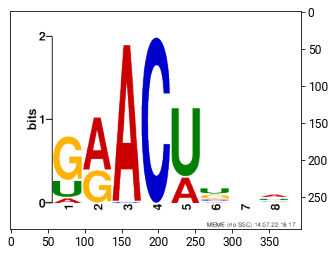

In [21]:
meme(m6anet_sitemodfrac)
!conda run -n meme meme temp_fasta.fa -oc meme_m6anet/ -rna  -objfun cd -mod zoops

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('meme_m6anet/logo1.png')
imgplot = plt.imshow(img)